# Import Libraries

In [54]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# Technical indicators
import ta

# Deep learning (TensorFlow / Keras)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC, Precision, Recall

# Hyperparameter tuning
import optuna

# Evaluation metrics
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay


In [18]:
raw_SPY_intraday_cleaned_df = pd.read_csv("SPY_intraday_cleaned_FINAL.csv")

In [19]:
raw_SPY_intraday_cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177124 entries, 0 to 177123
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   timestamp_utc  177124 non-null  object 
 1   open           177124 non-null  float64
 2   high           177124 non-null  float64
 3   low            177124 non-null  float64
 4   close          177124 non-null  float64
 5   volume         177124 non-null  float64
 6   timestamp_ny   177124 non-null  object 
 7   ret            177124 non-null  float64
 8   vol_5m         177124 non-null  float64
 9   vol_30m        177124 non-null  float64
 10  is_outlier_z5  177124 non-null  bool   
dtypes: bool(1), float64(8), object(2)
memory usage: 13.7+ MB


# Create features

In [20]:
# Copy dataset
SPY_intraday_cleaned_df = raw_SPY_intraday_cleaned_df.copy()

# Time format
SPY_intraday_cleaned_df['timestamp_utc'] = pd.to_datetime(SPY_intraday_cleaned_df['timestamp_utc'])
SPY_intraday_cleaned_df = SPY_intraday_cleaned_df.set_index('timestamp_utc').sort_index()


price_cols = ['open', 'high', 'low', 'close', 'volume']

# Momentum
SPY_intraday_cleaned_df['log_ret'] = np.log(SPY_intraday_cleaned_df['close'] / SPY_intraday_cleaned_df['close'].shift(1))

# Rolling returns
SPY_intraday_cleaned_df['ret_15m'] = SPY_intraday_cleaned_df['close'].pct_change(3)   # assuming 5min data → 3 intervals = 15min
SPY_intraday_cleaned_df['ret_30m'] = SPY_intraday_cleaned_df['close'].pct_change(6)

# Volatility
SPY_intraday_cleaned_df['vol_15m'] = SPY_intraday_cleaned_df['log_ret'].rolling(3).std()
SPY_intraday_cleaned_df['vol_60m'] = SPY_intraday_cleaned_df['log_ret'].rolling(12).std()

# Trend
SPY_intraday_cleaned_df['MA_short'] = SPY_intraday_cleaned_df['close'].rolling(12).mean()   # 1 hour
SPY_intraday_cleaned_df['MA_long'] = SPY_intraday_cleaned_df['close'].rolling(60).mean()    # 5 hours
SPY_intraday_cleaned_df['MA_ratio'] = SPY_intraday_cleaned_df['MA_short'] / SPY_intraday_cleaned_df['MA_long']   # relative trend

# Technical Indicators
SPY_intraday_cleaned_df['MACD'] = ta.trend.macd(SPY_intraday_cleaned_df['close'])
SPY_intraday_cleaned_df['RSI'] = ta.momentum.rsi(SPY_intraday_cleaned_df['close'], window=14)
SPY_intraday_cleaned_df['ATR'] = ta.volatility.average_true_range(SPY_intraday_cleaned_df['high'], SPY_intraday_cleaned_df['low'], SPY_intraday_cleaned_df['close'], window=14)


# Time features
SPY_intraday_cleaned_df['hour'] = SPY_intraday_cleaned_df.index.hour
SPY_intraday_cleaned_df['dayofweek'] = SPY_intraday_cleaned_df.index.dayofweek

SPY_intraday_cleaned_df['hour_sin'] = np.sin(2 * np.pi * SPY_intraday_cleaned_df['hour'] / 24)
SPY_intraday_cleaned_df['hour_cos'] = np.cos(2 * np.pi * SPY_intraday_cleaned_df['hour'] / 24)
SPY_intraday_cleaned_df['dow_sin'] = np.sin(2 * np.pi * SPY_intraday_cleaned_df['dayofweek'] / 7)
SPY_intraday_cleaned_df['dow_cos'] = np.cos(2 * np.pi * SPY_intraday_cleaned_df['dayofweek'] / 7)

SPY_intraday_cleaned_df


,open,high,low,close,volume,timestamp_ny,ret,vol_5m,vol_30m,is_outlier_z5,...,MA_ratio,MACD,RSI,ATR,hour,dayofweek,hour_sin,hour_cos,dow_sin,dow_cos
timestamp_utc,,,,,,,,,,,,,,,,,,,,,
2024-01-02 15:00:00+00:00,472.275,472.600,472.135,472.460,414610.0,2024-01-02 10:00:00-05:00,0.000402,0.000315,0.000376,False,...,NaN,NaN,NaN,0.000000,15,1,-0.707107,-0.707107,0.781831,0.623490
2024-01-02 15:01:00+00:00,472.460,472.540,472.370,472.540,203703.0,2024-01-02 10:01:00-05:00,0.000169,0.000181,0.000372,False,...,NaN,NaN,NaN,0.000000,15,1,-0.707107,-0.707107,0.781831,0.623490
2024-01-02 15:02:00+00:00,472.540,472.631,472.470,472.515,161592.0,2024-01-02 10:02:00-05:00,-0.000053,0.000274,0.000370,False,...,NaN,NaN,NaN,0.000000,15,1,-0.707107,-0.707107,0.781831,0.623490
2024-01-02 15:03:00+00:00,472.540,472.710,472.500,472.580,127841.0,2024-01-02 10:03:00-05:00,0.000138,0.000251,0.000370,False,...,NaN,NaN,NaN,0.000000,15,1,-0.707107,-0.707107,0.781831,0.623490
2024-01-02 15:04:00+00:00,472.570,472.620,472.460,472.556,225236.0,2024-01-02 10:04:00-05:00,-0.000051,0.000188,0.000370,False,...,NaN,NaN,NaN,0.000000,15,1,-0.707107,-0.707107,0.781831,0.623490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-22 19:56:00+00:00,667.730,668.080,667.700,667.960,266965.0,2025-10-22 15:56:00-04:00,0.000359,0.000365,0.000306,False,...,1.000696,0.099081,55.717839,0.338752,19,2,-0.965926,0.258819,0.974928,-0.222521
2025-10-22 19:57:00+00:00,667.970,667.970,667.500,667.560,426714.0,2025-10-22 15:57:00-04:00,-0.000599,0.000387,0.000325,False,...,1.000675,0.071025,47.097785,0.348127,19,2,-0.965926,0.258819,0.974928,-0.222521
2025-10-22 19:58:00+00:00,667.550,667.630,667.410,667.520,600191.0,2025-10-22 15:58:00-04:00,-0.000060,0.000363,0.000307,False,...,1.000628,0.045045,46.325949,0.338975,19,2,-0.965926,0.258819,0.974928,-0.222521


# Create Target Variable

In [21]:
# Define future return over next 5-minute window
SPY_intraday_cleaned_df['future_ret_5m'] = (
    SPY_intraday_cleaned_df['close'].shift(-5) / SPY_intraday_cleaned_df['close'] - 1
)

pos_thresh = 0

SPY_intraday_cleaned_df['y_next5_up'] = (
    SPY_intraday_cleaned_df['future_ret_5m'] > pos_thresh
).astype(int)

# Drop rows where future return cannot be computed (the last 5 rows)
SPY_intraday_cleaned_df = SPY_intraday_cleaned_df.dropna(subset=['future_ret_5m'])


In [22]:
SPY_intraday_cleaned_df["y_next5_up"]

timestamp_utc
2024-01-02 15:00:00+00:00    0
2024-01-02 15:01:00+00:00    0
2024-01-02 15:02:00+00:00    0
2024-01-02 15:03:00+00:00    0
2024-01-02 15:04:00+00:00    0
                            ..
2025-10-22 19:51:00+00:00    0
2025-10-22 19:52:00+00:00    0
2025-10-22 19:53:00+00:00    0
2025-10-22 19:54:00+00:00    0
2025-10-22 19:55:00+00:00    1
Name: y_next5_up, Length: 177119, dtype: int32

In [23]:
counts = SPY_intraday_cleaned_df['y_next5_up'].value_counts()
percentages = 100 * counts / counts.sum()
print(pd.DataFrame({'Count': counts, 'Percentage': percentages}))


            Count  Percentage
y_next5_up                   
1           91010   51.383533
0           86109   48.616467


In [24]:
future_ret = SPY_intraday_cleaned_df['future_ret_5m']
print(future_ret.describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))


count    177119.000000
mean          0.000010
std           0.001153
min          -0.041421
1%           -0.002691
5%           -0.001261
10%          -0.000815
25%          -0.000329
50%           0.000019
75%           0.000364
90%           0.000806
95%           0.001198
99%           0.002668
max           0.045386
Name: future_ret_5m, dtype: float64


# Feature Selection

In [25]:
feature_cols = [
    'volume',
    'ret', 'log_ret', 'ret_15m', 'ret_30m',
    'vol_5m', 'vol_15m', 'vol_30m', 'vol_60m',
    'MA_ratio', 'MACD', 'RSI', 'ATR',
    'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos'
]

target_col = 'y_next5_up'

# Train test split

In [26]:
# Ensure index is datetime and sorted
SPY_intraday_cleaned_df = SPY_intraday_cleaned_df.sort_index()
dates = SPY_intraday_cleaned_df.index

# Define chronological cut-offs
train_end = '2025-04-30'
val_end   = '2025-08-31'

train_df = SPY_intraday_cleaned_df.loc[:train_end]
val_df   = SPY_intraday_cleaned_df.loc[train_end:val_end]
test_df  = SPY_intraday_cleaned_df.loc[val_end:]

print(f"Train: {train_df.index.min()} → {train_df.index.max()}  ({len(train_df)} samples)")
print(f"Val:   {val_df.index.min()} → {val_df.index.max()}  ({len(val_df)} samples)")
print(f"Test:  {test_df.index.min()} → {test_df.index.max()}  ({len(test_df)} samples)")


Train: 2024-01-02 15:00:00+00:00 → 2025-04-30 20:00:00+00:00  (129993 samples)
Val:   2025-04-30 13:30:00+00:00 → 2025-08-29 20:00:00+00:00  (33055 samples)
Test:  2025-09-02 13:30:00+00:00 → 2025-10-22 19:55:00+00:00  (14462 samples)


Split around major volatility regime shifts (e.g., high-vol periods vs stable).

# Feature Preprocessing

## Scale numeric features

In [27]:
scaler = StandardScaler()
scaler.fit(train_df[feature_cols])

# Transform each split
train_df.loc[:, feature_cols] = scaler.transform(train_df[feature_cols])
val_df.loc[:, feature_cols]   = scaler.transform(val_df[feature_cols])
test_df.loc[:, feature_cols]  = scaler.transform(test_df[feature_cols])


## Create lookback window

In [28]:
def make_sequences(df, feature_cols, target_col, lookback=60):
    X, y = [], []
    data = df[feature_cols].values
    labels = df[target_col].values

    for i in range(lookback, len(df)):
        X.append(data[i - lookback:i])
        y.append(labels[i])

    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

# Create rolling sequences
lookback = 60  # 60 timesteps = past 60 minutes
target_col = 'y_next5_up'

X_train, y_train = make_sequences(train_df, feature_cols, target_col, lookback)
X_val, y_val     = make_sequences(val_df,   feature_cols, target_col, lookback)
X_test, y_test   = make_sequences(test_df,  feature_cols, target_col, lookback)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (129933, 60, 17), Val: (32995, 60, 17), Test: (14402, 60, 17)


## Create class weights

In [29]:
# Compute weights based on y_train
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert to dictionary form (needed for model.fit)
class_weights = dict(enumerate(class_weights))
print("Original class weights:", class_weights)

# Strengthen the minority class weight (double or triple)
boost_factor = 100   
class_weights[1] = class_weights[1] * boost_factor

print(f"Boosted class weights (×{boost_factor}):", class_weights)


Original class weights: {0: 1.0238523001276536, 1: 0.9772337545126354}
Boosted class weights (×100): {0: 1.0238523001276536, 1: 97.72337545126354}


# Model Architecture

In [30]:
def build_cnn_lstm(input_shape):
    model = Sequential([
        # CNN feature extractor
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),

        # Temporal modeling (LSTM)
        LSTM(64, return_sequences=False),
        Dropout(0.2),

        # Fully connected classifier
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(1, activation='sigmoid')   # Binary classificatioan
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-5),
         metrics=[
            AUC(name='auc'),
            Precision(name='precision'),
            Recall(name='recall')
        ]
    )
    return model


input_shape = (X_train.shape[1], X_train.shape[2])

model = build_cnn_lstm(input_shape)
model.summary()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 60, 64)            3328      
                                                                 
 batch_normalization (Batch  (None, 60, 64)            256       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 30, 64)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)               

# Baseline Model

## Model Training

In [31]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,          # stop after 3 epochs with no improvement
    restore_best_weights=True
)

In [32]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,           
    batch_size=32,      
    verbose=1,
    class_weight=class_weights,
    callbacks=[early_stop]
)
 

Epoch 1/50

4061/4061 [==============================] - 37s 8ms/step - loss: 34.5153 - auc: 0.5008 - precision: 0.5117 - recall: 0.9997 - val_loss: 0.6924 - val_auc: 0.5000 - val_precision: 0.5249 - val_recall: 1.0000
Epoch 2/50
4061/4061 [==============================] - 33s 8ms/step - loss: 33.5488 - auc: 0.4984 - precision: 0.5116 - recall: 1.0000 - val_loss: 0.6920 - val_auc: 0.5000 - val_precision: 0.5249 - val_recall: 1.0000
Epoch 3/50
4061/4061 [==============================] - 36s 9ms/step - loss: 32.6034 - auc: 0.4994 - precision: 0.5116 - recall: 1.0000 - val_loss: 0.6920 - val_auc: 0.5000 - val_precision: 0.5249 - val_recall: 1.0000
Epoch 4/50
4061/4061 [==============================] - 37s 9ms/step - loss: 31.6793 - auc: 0.4981 - precision: 0.5116 - recall: 1.0000 - val_loss: 0.6924 - val_auc: 0.5000 - val_precision: 0.5249 - val_recall: 1.0000
Epoch 5/50
4061/4061 [==============================] - 34s 8ms/step - loss: 30.7727 - auc: 0.5023 - precision: 0.5116 - recall

## Model Results

In [33]:
print(f"Final training AUC: {history.history['auc'][-1]:.4f}")
print(f"Final validation AUC: {history.history['val_auc'][-1]:.4f}")

print(f"Final training Precision: {history.history['precision'][-1]:.4f}")
print(f"Final validation Precision: {history.history['val_precision'][-1]:.4f}")

print(f"Final training Recall: {history.history['recall'][-1]:.4f}")
print(f"Final validation Recall: {history.history['val_recall'][-1]:.4f}")


Final training AUC: 0.5011
Final validation AUC: 0.5000
Final training Precision: 0.5116
Final validation Precision: 0.5249
Final training Recall: 1.0000
Final validation Recall: 1.0000


In [34]:
# Predict probabilities of upward move
y_prob = model.predict(X_test, verbose=0).ravel()

In [ ]:
print("Min prob:", np.min(y_prob))
print("Max prob:", np.max(y_prob))
print("Mean prob:", np.mean(y_prob))
print("Unique (rounded):", np.unique(np.round(y_prob, 2))[:20])


Min prob: 0.5298339
Max prob: 0.5298339
Mean prob: 0.52983385
Unique (rounded): [0.53]


AUC Score: 0.5000


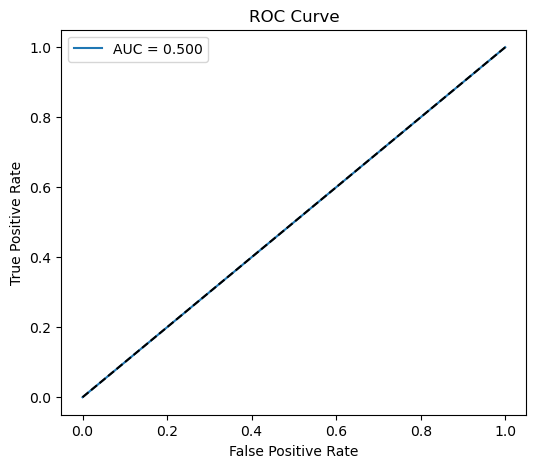

In [ ]:
# Compute AUC
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC Score: {auc_score:.4f}")

# Optional: Plot ROC curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


# Hyperparameter tuning

In [ ]:
# Compute class weights (to fix imbalance)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

def build_model(trial, input_shape):
    model = Sequential()
    
    # CNN layer
    filters = trial.suggest_categorical("filters", [32, 64, 128])
    kernel_size = trial.suggest_categorical("kernel_size", [2, 3, 5])
    model.add(Conv1D(filters=filters, kernel_size=kernel_size,
                     activation='relu', padding='same',
                     input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    
    dropout_cnn = trial.suggest_float("dropout_cnn", 0.1, 0.5)
    model.add(Dropout(dropout_cnn))
    
    # LSTM layer
    lstm_units = trial.suggest_categorical("lstm_units", [32, 64, 128])
    model.add(LSTM(lstm_units, return_sequences=False))
    
    dropout_lstm = trial.suggest_float("dropout_lstm", 0.1, 0.5)
    model.add(Dropout(dropout_lstm))
    
    # Dense layer
    dense_units = trial.suggest_categorical("dense_units", [16, 32, 64])
    model.add(Dense(dense_units, activation='relu'))
    
    dropout_dense = trial.suggest_float("dropout_dense", 0.1, 0.5)
    model.add(Dropout(dropout_dense))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Optimizer
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    optimizer = Adam(learning_rate=lr)
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=[AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
    )
    return model


def objective(trial):
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_model(trial, input_shape)
    
    es = EarlyStopping(patience=2, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=trial.suggest_categorical("batch_size", [16, 32]),
        verbose=0,
        class_weight=class_weights,
        callbacks=[es]
    )
    
    val_auc = history.history['val_auc'][-1]
    return val_auc


In [38]:
optuna.logging.set_verbosity(optuna.logging.INFO)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=2, timeout=600)  # 2 trials



[I 2025-11-10 13:47:51,040] A new study created in memory with name: no-name-e4f7a005-0f80-49d7-be95-12860b886266
[I 2025-11-10 13:50:26,374] Trial 0 finished with value: 0.5 and parameters: {'filters': 32, 'kernel_size': 5, 'dropout_cnn': 0.303606409543755, 'lstm_units': 64, 'dropout_lstm': 0.3008498101219315, 'dense_units': 64, 'dropout_dense': 0.10889873255364294, 'learning_rate': 2.3673340040406994e-05, 'batch_size': 16}. Best is trial 0 with value: 0.5.
[I 2025-11-10 13:53:54,055] Trial 1 finished with value: 0.5 and parameters: {'filters': 32, 'kernel_size': 3, 'dropout_cnn': 0.16520266639644926, 'lstm_units': 128, 'dropout_lstm': 0.4565946911161294, 'dense_units': 32, 'dropout_dense': 0.38326951301937984, 'learning_rate': 5.0725912406664605e-05, 'batch_size': 16}. Best is trial 0 with value: 0.5.


# Final Model

In [ ]:
# Compute class weights (to address imbalance) 
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# Rebuild model using best Optuna parameters
def build_final_cnn_lstm(input_shape):
    model = Sequential([
        # CNN feature extractor
        Conv1D(filters=128, kernel_size=5, activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3386),

        # LSTM temporal layer
        LSTM(64, return_sequences=False),
        Dropout(0.3215),

        # Dense block
        Dense(16, activation='relu'),
        Dropout(0.2941),

        # Output layer
        Dense(1, activation='sigmoid')
    ])

    # Compile model
    optimizer = Adam(learning_rate=0.0006463)
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=[AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
    )
    return model

# Train with Early Stopping
input_shape = (X_train.shape[1], X_train.shape[2])
final_model = build_final_cnn_lstm(input_shape)

es = EarlyStopping(patience=5, restore_best_weights=True)

history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[es],
    verbose=1
)


Epoch 1/5
4061/4061 [==============================] - 43s 10ms/step - loss: 0.6934 - auc: 0.4995 - precision: 0.5112 - recall: 0.4203 - val_loss: 0.6933 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
4061/4061 [==============================] - 42s 10ms/step - loss: 0.6932 - auc: 0.4996 - precision: 0.5093 - recall: 0.4060 - val_loss: 0.6933 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
4061/4061 [==============================] - 42s 10ms/step - loss: 0.6932 - auc: 0.4990 - precision: 0.5109 - recall: 0.5400 - val_loss: 0.6932 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
4061/4061 [==============================] - 42s 10ms/step - loss: 0.6932 - auc: 0.4981 - precision: 0.5107 - recall: 0.4455 - val_loss: 0.6931 - val_auc: 0.5000 - val_precision: 0.5249 - val_recall: 1.0000
Epoch 5/5
4061/4061 [==============================] - 40s 10ms/step - loss: 0.6932 - auc: 0.4979 - precisio

## Model Results

In [48]:
results = final_model.evaluate(X_val, y_val, verbose=0)
print(f"Final Validation AUC: {results[1]:.4f}")
print(f"Final Validation Precision: {results[2]:.4f}")
print(f"Final Validation Recall: {results[3]:.4f}")


Final Validation AUC: 0.5000
Final Validation Precision: 0.5249
Final Validation Recall: 1.0000


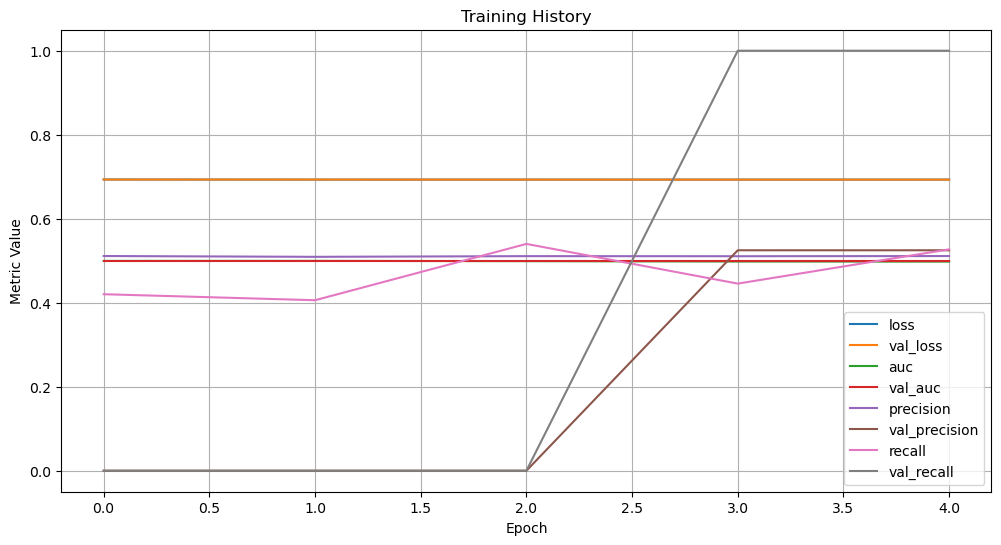

In [47]:
# Convert training history to DataFrame
history_df = pd.DataFrame(history.history)

history_df[['loss','val_loss','auc','val_auc','precision','val_precision','recall','val_recall']].plot(figsize=(12,6))
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.grid(True)
plt.show()


In [49]:
# Predict probabilities of positive class (e.g. market up)
y_pred_proba = final_model.predict(X_test)

451/451 [==============================] - 2s 3ms/step


In [ ]:
# Flatten arrays to make sure they match shapes
y_true = y_test.flatten()
y_pred = (y_pred_proba.flatten() > 0.5).astype(int)  # convert probabilities to binary (threshold = 0.5)

# Compute metrics
test_auc = roc_auc_score(y_true, y_pred_proba)
test_precision = precision_score(y_true, y_pred, zero_division=0)
test_recall = recall_score(y_true, y_pred, zero_division=0)

print(f"Test AUC: {test_auc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")


Test AUC: 0.5000
Test Precision: 0.5090
Test Recall: 1.0000



Confusion Matrix:
[[   0 7072]
 [   0 7330]]


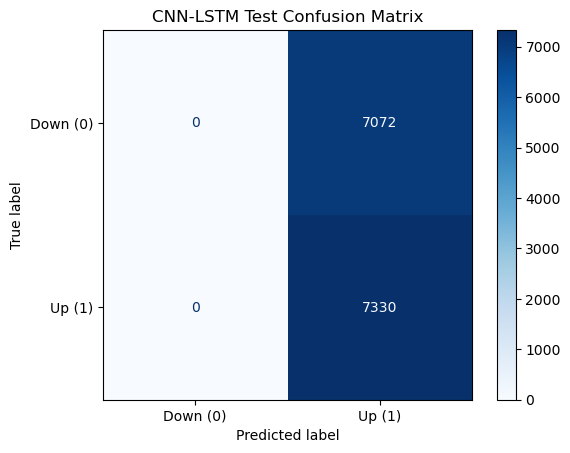

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print matrix
print("\nConfusion Matrix:")
print(cm)

# Optional: visualize it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down (0)", "Up (1)"])
disp.plot(cmap='Blues', values_format='d')
plt.title("CNN-LSTM Test Confusion Matrix")
plt.show()


## Export Results

In [ ]:
# Create DataFrame with predictions and actuals
results_df = pd.DataFrame({
    'timestamp': test_df.index[-len(y_pred_proba):],  # align timestamps
    'y_true': y_test,
    'y_pred_proba': y_pred_proba.flatten()  # flatten from (n,1) to (n,)
})

# Remove timezone before exporting
results_df['timestamp'] = results_df['timestamp'].dt.tz_localize(None)

# Export to Excel
results_df.to_excel('cnn_lstm_predictions.xlsx', index=False)
print("Predictions saved to cnn_lstm_predictions.xlsx")


Predictions saved to cnn_lstm_predictions.xlsx
